Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Transport Mode Statistics (point-level):
                  Count  Percentage
transport_mode                     
walk            1247539   25.390224
bus             1147375   23.351661
bike             738910   15.038480
train            494072   10.055476
car              473614    9.639110
Unknown          361741    7.362243
subway           245715    5.000853
taxi             190215    3.871303
airplane           8611    0.175253
boat               3526    0.071762
run                1975    0.040196
motorcycle          169    0.003440


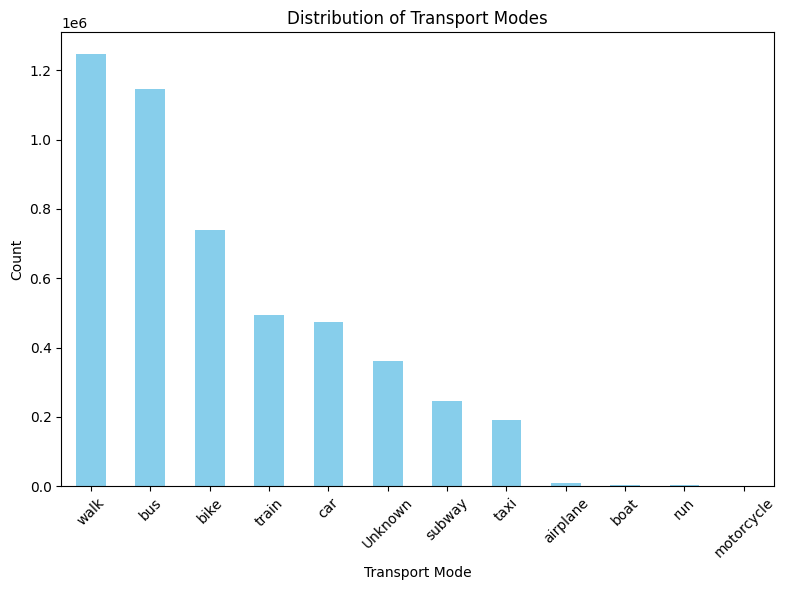

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Total Trips: 9775
Trips with only 'Unknown' transport mode: 0


In [4]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def compute_transport_mode_statistics(directory):
    """
    Reads all GeoJSON files in the specified directory, extracts the 'transport_mode'
    column from each file, and computes statistics including the count and percentage
    for each mode across all trajectory points.
    """
    # List to accumulate transport_mode data from each file
    transport_modes = []
    
    for file in os.listdir(directory):
        if file.endswith('.geojson'):
            file_path = os.path.join(directory, file)
            try:
                gdf = gpd.read_file(file_path)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
            
            if "transport_mode" in gdf.columns:
                # Append all transport_mode values from this file
                transport_modes.extend(gdf["transport_mode"].tolist())
            else:
                print(f"File {file_path} does not contain a 'transport_mode' column.")
    
    if not transport_modes:
        print("No transport_mode data found in the provided directory.")
        return None
    
    # Create a DataFrame and compute counts and percentages
    mode_df = pd.DataFrame(transport_modes, columns=["transport_mode"])
    mode_counts = mode_df["transport_mode"].value_counts()
    total_points = mode_df.shape[0]
    mode_percentages = (mode_counts / total_points) * 100
    
    stats_df = pd.DataFrame({
        "Count": mode_counts,
        "Percentage": mode_percentages
    })
    
    return stats_df

def compute_trip_statistics(directory):
    """
    Counts the total number of trips (i.e., GeoJSON files) in the directory and,
    among those, how many contain only 'Unknown' for the transport_mode.
    """
    total_trips = 0
    trips_all_unknown = 0
    for file in os.listdir(directory):
        if file.endswith('.geojson'):
            file_path = os.path.join(directory, file)
            try:
                gdf = gpd.read_file(file_path)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
            total_trips += 1
            if "transport_mode" in gdf.columns:
                unique_modes = gdf["transport_mode"].unique()
                # Count the trip if the only mode present is 'Unknown'
                if len(unique_modes) == 1 and unique_modes[0] == "Unknown":
                    trips_all_unknown += 1
            else:
                print(f"File {file_path} does not have a 'transport_mode' column.")
    return total_trips, trips_all_unknown

# Define the folder that holds the cleaned trajectories (GeoJSON files)
cleaned_folder = "./Cleaned_Trajectories"  # Adjust if necessary

# Compute transport mode statistics across all points
stats_df = compute_transport_mode_statistics(cleaned_folder)

if stats_df is not None:
    print("Transport Mode Statistics (point-level):")
    print(stats_df)
    
    # Plotting the distribution of transport modes
    plt.figure(figsize=(8, 6))
    stats_df["Count"].plot(kind="bar", color="skyblue")
    plt.xlabel("Transport Mode")
    plt.ylabel("Count")
    plt.title("Distribution of Transport Modes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Compute trip-level statistics
total_trips, trips_all_unknown = compute_trip_statistics(cleaned_folder)
print(f"Total Trips: {total_trips}")
print(f"Trips with only 'Unknown' transport mode: {trips_all_unknown}")


In [7]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_trip_summaries(file_path):
    """
    Parse the trip_summaries.txt file and extract trip details into a DataFrame.
    Currently, this function extracts the 'transport_mode' for each trip.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Each trip summary is assumed to be separated by two newlines.
    trips = content.strip().split("\n\n")
    data = []
    
    for trip in trips:
        # Use regex to extract the transport mode line
        tm_match = re.search(r"- Transport Mode:\s*(.*)", trip)
        transport_mode = tm_match.group(1).strip() if tm_match else "Unknown"
        
        # Optionally, other fields (like start/end time, distance, etc.) can be extracted.
        data.append({
            "transport_mode": transport_mode,
            # "start": start_match.group(1) if start_match else None,
            # "end": end_match.group(1) if end_match else None,
            # Add more fields as needed...
        })
    
    df = pd.DataFrame(data)
    return df

def compute_trip_summary_stats(file_path):
    """
    Compute statistics (counts and percentages) for the transport modes
    in the trip_summaries.txt file.
    """
    df = parse_trip_summaries(file_path)
    if df.empty:
        print("No trip summaries found in the file.")
        return None
    
    mode_counts = df['transport_mode'].value_counts()
    total_count = len(df)
    mode_percentages = (mode_counts / total_count) * 100
    
    stats_df = pd.DataFrame({
        "Count": mode_counts,
        "Percentage": mode_percentages
    })
    
    return stats_df, total_count

def plot_trip_summary_stats(stats_df):
    """
    Plot a bar chart for the transport mode statistics.
    """
    plt.figure(figsize=(8, 6))
    stats_df["Count"].plot(kind="bar", color="skyblue")
    plt.xlabel("Transport Mode")
    plt.ylabel("Count")
    plt.title("Transport Mode Distribution (Trip Summaries)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
file_path = "./trip_summaries.txt"  # Adjust the path if necessary
stats_df, total_count = compute_trip_summary_stats(file_path)
if stats_df is not None:
    print("Trip Summary Statistics:")
    print(stats_df)
    print(f"Total Trip Count: {total_count}")

Trip Summary Statistics:
                Count  Percentage
transport_mode                   
walk              442   30.779944
bike              248   17.270195
bus               242   16.852368
car               169   11.768802
Mixed             138    9.610028
subway             65    4.526462
taxi               53    3.690808
train              37    2.576602
Unknown            35    2.437326
airplane            6    0.417827
boat                1    0.069638
Total Trip Count: 1436


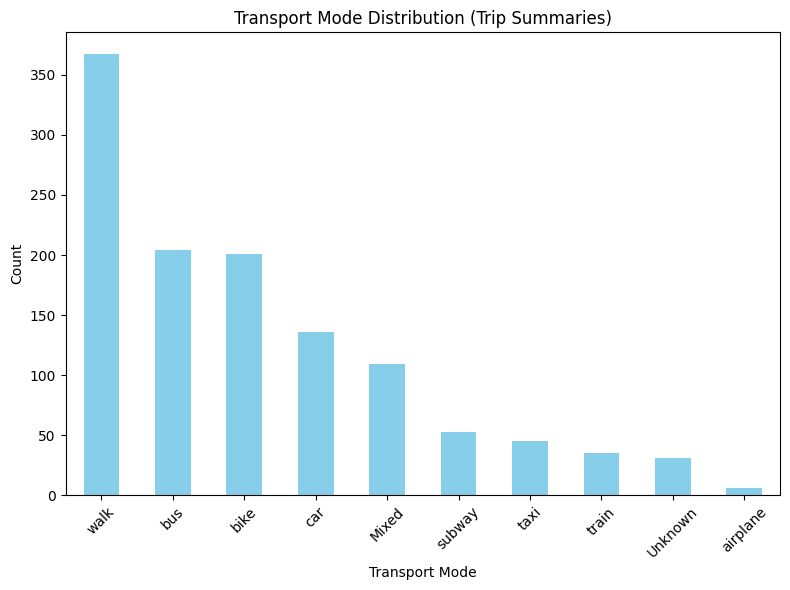

In [16]:
if stats_df is not None:
    plot_trip_summary_stats(stats_df)

Subtrajectory counts by transport mode:
bus: 33
walk: 50
car: 5
taxi: 10
bike: 21

Total number of subtrajectories: 119


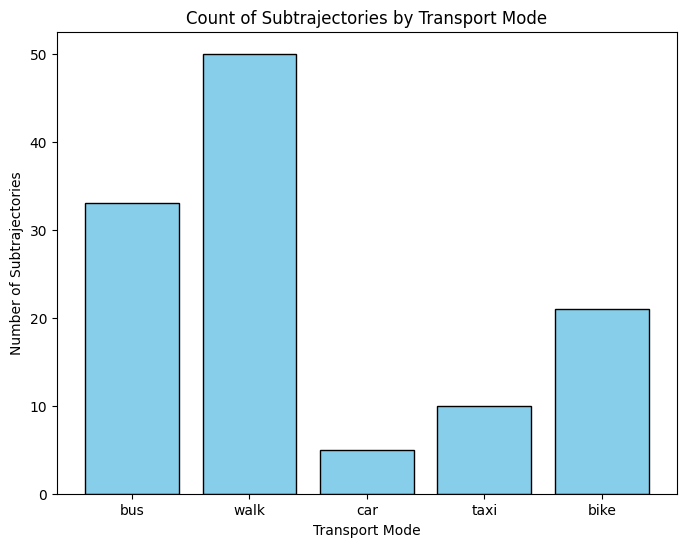

In [5]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Set the folder where the cleaned LLM subtrajectories are stored.
folder_path = "./Sub_Trajectories_Cleaned"

# Use a defaultdict to count subtrajectories per transport mode.
mode_counts = defaultdict(int)

# Traverse the folder structure and count files by transport mode.
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".geojson"):
            # Assuming filenames are like "bike_cleaned_llm.geojson" or "walk_cleaned_llm.geojson"
            mode = file.split('_')[0]  # Extract the first part as the transport mode.
            mode_counts[mode] += 1

# Print the counts.
print("Subtrajectory counts by transport mode:")
for mode, count in mode_counts.items():
    print(f"{mode}: {count}")

# Calculate and print the total number of subtrajectories.
total_subtrajectories = sum(mode_counts.values())
print(f"\nTotal number of subtrajectories: {total_subtrajectories}")

# Plot a bar chart for visualization.
modes = list(mode_counts.keys())
counts = [mode_counts[mode] for mode in modes]

plt.figure(figsize=(8, 6))
plt.bar(modes, counts, color='skyblue', edgecolor='black')
plt.xlabel("Transport Mode")
plt.ylabel("Number of Subtrajectories")
plt.title("Count of Subtrajectories by Transport Mode")
plt.show()

In [8]:
file_path = "./sub_trip_summaries.txt"  # Adjust the path if necessary
stats_df, total_count = compute_trip_summary_stats(file_path)
if stats_df is not None:
    print("Trip Summary Statistics:")
    print(stats_df)
    print(f"Total Trip Count: {total_count}")

Trip Summary Statistics:
                Count  Percentage
transport_mode                   
walk               50   42.016807
bus                33   27.731092
bike               21   17.647059
taxi               10    8.403361
car                 5    4.201681
Total Trip Count: 119


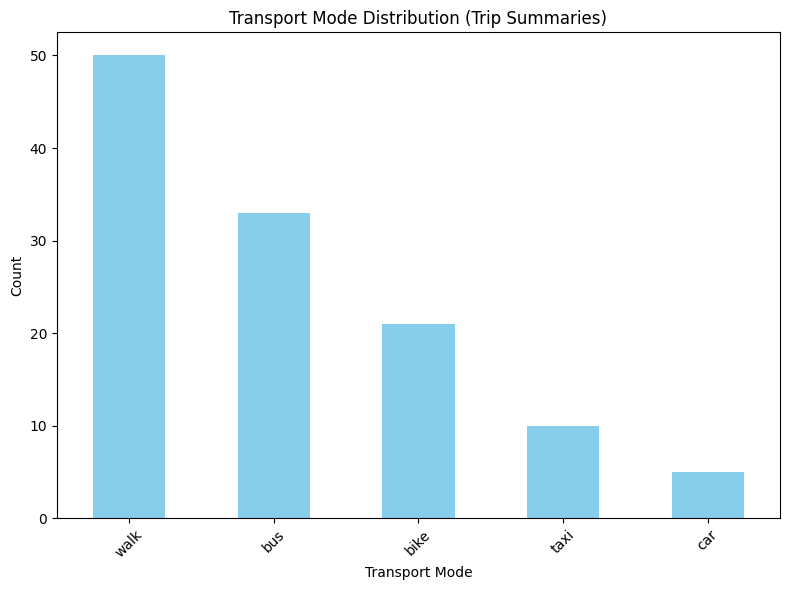

In [9]:
if stats_df is not None:
    plot_trip_summary_stats(stats_df)